##### Imports and functions

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def get_metrics(modellist, X, y):
    for model in modellist:
        X_test, X_train, y_test, y_train = train_test_split(X,y, test_size=0.3)
        model.fit(X_train,y_train)
        score = model.score(X_test, y_test)
        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, average = 'weighted')
        recall = recall_score(y_test, pred, average= 'weighted')
        f1 = f1_score(y_test, pred, average = 'weighted')
        print('Score for', str(model)[:22],':',score)
        print('Accuracy for', str(model)[:22], ':', accuracy)
        print('Precision for', str(model)[:22], ':', precision)
        print('Recall for', str(model)[:22], ':', recall)
        print('F1 for', str(model)[:22], ':', f1)

def get_scores_predict(modellist, X, y):
    X_test, X_train, y_test, y_train = train_test_split(X,y, test_size=0.3)
    for model in modellist:
        model.fit(X_train,y_train)
        score = model.score(X_test, y_test)
        print('Score for', str(model)[:22],':',score)

def combine_diseases(col):
    for disease in col:
        diseasesmanaged.add(disease)

def map_disease(l, disease):
    if disease in l:
        return 1
    else:
        return 0

#### Initialise SQL query engine to AWS

In [3]:
cnx = create_engine('postgresql://kenny@34.203.14.69:5432/mcnulty')

#### Pulling Medical Plan Attributes Table from psql Database

In [ ]:
planattmeddf = pd.read_sql_query('''SELECT IssuerActuarialValue,
                                    CSRVariationType,
                                    DentalOnlyPlan,
                                    DiseaseManagementProgramsOffered,
                                    FirstTierUtilization,
                                    IsHSAEligible,
                                    IsNewPlan,
                                    IsNoticeRequiredForPregnancy,
                                    IsReferralRequiredForSpecialist,
                                    MarketCoverage,
                                    MedicalDrugDeductiblesIntegrated,
                                    MedicalDrugMaximumOutofPocketIntegrated,
                                    MetalLevel,
                                    PlanId,
                                    PlanType,
                                    StateCode,
                                    WellnessProgramOffered
                                    FROM planattributes
                                    WHERE DentalOnlyPlan = 'No'AND IssuerActuarialValue IS NOT NULL
                                    ''', cnx)

#### Data Cleaning for Usability in Classification Models

In [14]:
planattmeddf.firsttierutilization = planattmeddf.firsttierutilization.map(lambda x: float(x.rstrip('%')))
planattmeddf.issueractuarialvalue = planattmeddf.issueractuarialvalue.map(lambda x: float(x.rstrip('%')))
planattmeddf.isnoticerequiredforpregnancy = planattmeddf.isnoticerequiredforpregnancy.replace('NO','No')

In [16]:
planattmeddf = planattmeddf.dropna()

diseasesmanaged = set()

planattmeddf.diseasemanagementprogramsoffered = planattmeddf.diseasemanagementprogramsoffered.map(lambda x: x.split(','))

planattmeddf.diseasemanagementprogramsoffered.apply(combine_diseases)

In [138]:
planattmeddf.columns

Index(['issueractuarialvalue', 'csrvariationtype', 'dentalonlyplan',
       'diseasemanagementprogramsoffered', 'firsttierutilization',
       'ishsaeligible', 'isnewplan', 'isnoticerequiredforpregnancy',
       'isreferralrequiredforspecialist', 'marketcoverage',
       'medicaldrugdeductiblesintegrated',
       'medicaldrugmaximumoutofpocketintegrated', 'metallevel', 'planid',
       'plantype', 'statecode', 'wellnessprogramoffered', ' Diabetes',
       'Asthma', ' Asthma', '  Pain Management', 'Diabetes', 'Depression',
       ' Weight Loss Programs', ' Heart Disease', ' Pain Management',
       ' High Blood Pressure & High Cholesterol', '  Diabetes', ' Depression',
       'Heart Disease', ' Pregnancy', ' Low Back Pain', 'Pregnancy',
       'combdiabetes', 'combPregnancy', 'combAsthma'],
      dtype='object')

Creating Dummy Variables for specific fields

In [21]:
for disease in diseasesmanaged:
    planattmeddf[disease] = planattmeddf.diseasemanagementprogramsoffered.map(lambda x: map_disease(x, disease))

In [22]:
planattmeddf['combdiabetes']=planattmeddf.iloc[:,20]+planattmeddf.iloc[:,21]+planattmeddf.iloc[:,22]

planattmeddf['combPregnancy'] = planattmeddf.iloc[:,25]+planattmeddf.iloc[:,27]

planattmeddf['combAsthma'] = planattmeddf.iloc[:,18]+planattmeddf.iloc[:,23]

In [25]:
csrdf = pd.get_dummies(planattmeddf.csrvariationtype)

In [26]:
#Flat df + csrdummy
padf = pd.concat([planattmeddf, csrdf], axis=1)

In [225]:
padf.ishsaeligible = padf.ishsaeligible.replace(['Yes','No'],['IsHsaEligYes','IsHsaEligNo'])

In [27]:
ishsadf = pd.get_dummies(padf.ishsaeligible)

In [28]:
#CSR dummy+isHSA df
padf2 = pd.concat([padf, ishsadf], axis=1)

In [238]:
padf2.isnewplan.value_counts()

New         19391
Existing     9466
Name: isnewplan, dtype: int64

In [239]:
padf2.isnewplan = padf2.isnewplan.replace(['New','Existing'],['IsNewPlanNew','IsNewPlanExisting'])

In [29]:
isnewdf = pd.get_dummies(padf2.isnewplan)

In [30]:
#CSR+isHSA+isNew
padf3 = pd.concat([padf2, isnewdf], axis=1)

In [260]:
padf3.isnoticerequiredforpregnancy = padf3.isnoticerequiredforpregnancy.replace(['Yes','No'],['IsPregYes','IsPregNo'])

In [261]:
padf3.isreferralrequiredforspecialist = padf3.isreferralrequiredforspecialist.replace(['Yes','No'],['IsSpecialistYes','IsSpecialistNo'])

In [264]:
padf3.marketcoverage = padf3.marketcoverage.replace(['Individual','SHOP (Small Group)'],['MrktCvrgIndividual','MrktCvrgSHOP'])

In [32]:
pregdf = pd.get_dummies(padf3.isnoticerequiredforpregnancy)

In [33]:
specialistdf = pd.get_dummies(padf3.isreferralrequiredforspecialist)

In [34]:
marketdf = pd.get_dummies(padf3.marketcoverage)

In [282]:
padf3.medicaldrugdeductiblesintegrated = padf3.medicaldrugdeductiblesintegrated.replace(['MdclDrgIntegratedYes','MdclDrgIntegratedNo'],['DeductiblesIntegratedYes','DeductiblesIntegratedNo']) 


In [35]:
mdcldrgintdf = pd.get_dummies(padf3.medicaldrugdeductiblesintegrated)

In [291]:
padf3.medicaldrugmaximumoutofpocketintegrated = padf2.medicaldrugmaximumoutofpocketintegrated.replace(['Yes','No'],['MOOPIntegratedYes','MOOPIntegratedNo'])

In [36]:
moopintdf = pd.get_dummies(padf3.medicaldrugmaximumoutofpocketintegrated)

In [297]:
padf3.plantype = padf3.plantype.replace(['EPO','HMO','POS','PPO'],['plantypeEPO','plantypeHMO','plantypePOS','plantypePPO'])

In [37]:
plantypedf = pd.get_dummies(padf3.plantype)

In [38]:
padftest = pd.concat([padf3, pregdf,specialistdf,marketdf,mdcldrgintdf,moopintdf], axis=1)

In [50]:
padf4 = pd.concat([padftest,plantypedf], axis=1)

,Pain Management,Diabetes,Depression,Weight Loss Programs,Heart Disease,Pain Management,High Blood Pressure & High Cholesterol,Diabetes,Depression,Heart Disease
0,0,0,0,0,1,0,1,0,1,0
1,0,0,0,0,1,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,1,0
4,0,0,0,0,1,0,1,0,1,0
5,0,0,0,0,1,0,1,0,1,0
6,0,0,0,0,1,0,1,0,1,0
7,0,0,0,0,1,0,1,0,1,0
8,0,0,0,0,1,0,1,0,1,0
9,0,0,0,0,1,0,1,0,1,0


In [149]:
planattmeddf.iloc[:5,:17]

,issueractuarialvalue,csrvariationtype,dentalonlyplan,diseasemanagementprogramsoffered,firsttierutilization,ishsaeligible,isnewplan,isnoticerequiredforpregnancy,isreferralrequiredforspecialist,marketcoverage,medicaldrugdeductiblesintegrated,medicaldrugmaximumoutofpocketintegrated,metallevel,planid,plantype,statecode,wellnessprogramoffered
0,70.11,Limited Cost Sharing Plan Variation,No,"[Asthma, Heart Disease, Depression, Diabete...",100.0,No,New,No,No,Individual,No,Yes,Silver,30751MT0550004-03,PPO,MT,Yes
1,73.02,73% AV Level Silver Plan,No,"[Asthma, Heart Disease, Depression, Diabete...",100.0,No,New,No,No,Individual,No,Yes,Silver,30751MT0550004-04,PPO,MT,Yes
2,74.00,73% AV Level Silver Plan,No,"[Asthma, Diabetes]",100.0,No,New,No,No,Individual,No,Yes,Silver,15438NE0170002-04,HMO,NE,Yes
3,100.00,Zero Cost Sharing Plan Variation,No,"[Asthma, Heart Disease, Depression, Diabete...",100.0,No,New,No,No,Individual,No,Yes,Silver,30751MT0570003-02,PPO,MT,Yes
4,70.79,Standard Silver Off Exchange Plan,No,"[Asthma, Heart Disease, Depression, Diabete...",100.0,No,New,No,No,Individual,No,Yes,Silver,30751MT0550003-00,PPO,MT,Yes


In [148]:
planattmeddf.iloc[:5,17:]

,Depression,Weight Loss Programs,High Blood Pressure & High Cholesterol,Pain Management,Heart Disease,Low Back Pain,Heart Disease,Pain Management,Depression,combdiabetes,combPregnancy,combAsthma
0,1,0,1,0,0,1,1,0,0,1,1,1
1,1,0,1,0,0,1,1,0,0,1,1,1
2,0,0,0,0,0,0,0,0,0,1,0,1
3,1,0,1,0,0,1,1,0,0,1,1,1
4,1,0,1,0,0,1,1,0,0,1,1,1


Cleaning of duplicate columns

In [40]:
y = padf4['metallevel']

In [94]:
X = padf4.drop(['metallevel', 'ishsaeligible', 'isnewplan', 'isnoticerequiredforpregnancy','issueractuarialvalue', 'isreferralrequiredforspecialist', 'marketcoverage', 'medicaldrugdeductiblesintegrated', 'medicaldrugmaximumoutofpocketintegrated','planid', 'plantype','statecode', ' Asthma','Asthma',' Diabetes','Diabetes','  Diabetes',' Pregnancy','Pregnancy','wellnessprogramoffered','diseasemanagementprogramsoffered', 'dentalonlyplan', 'csrvariationtype'],axis=1)

In [76]:
X.combAsthma.unique()

array([1, 0, 2])

In [95]:
X.combAsthma = X.combAsthma.replace(2,1)

In [96]:
X['combHeartDisease'] = X[' Heart Disease']+X['Heart Disease']

In [99]:
X['combDepression'] = X[' Depression']+X['Depression']

In [104]:
X['combPainManagement'] = X['  Pain Management']+X[' Pain Management']

In [115]:
X['combPlatOnCSR'] = X['Standard Platinum  On Exchange Plan']+X['Standard Platinum On Exchange Plan']

In [116]:
X.combPlatOnCSR.value_counts()

0    28252
1      605
Name: combPlatOnCSR, dtype: int64

In [101]:
X = X.drop([' Heart Disease','Heart Disease',' Depression','Depression'], axis=1)

In [107]:
X = X.drop(['  Pain Management',' Pain Management'], axis=1)

In [120]:
X = X.drop(['Standard Platinum  On Exchange Plan','Standard Platinum On Exchange Plan'],axis=1)

In [135]:
X.columns = ['firsttierutilization', ' Weight Loss Programs',
       ' High Blood Pressure & High Cholesterol', ' Low Back Pain',
       'combdiabetes', 'combPregnancy', 'combAsthma',
       '73% AV Level Silver Plan', '87% AV Level Silver Plan',
       '94% AV Level Silver Plan', 'Limited Cost Sharing Plan Variation',
       'Standard Bronze Off Exchange Plan', 'Standard Bronze On Exchange Plan',
       'Standard Gold Off Exchange Plan', 'Standard Gold On Exchange Plan',
       'Standard Platinum Off Exchange Plan',
       'Standard Silver Off Exchange Plan', 'Standard Silver On Exchange Plan',
       'Zero Cost Sharing Plan Variation','IsHsaEligNo','IsHsaEligYes', 'IsNewPlanExisting', 'IsNewPlanNew',
       'IsPregNo','IsPregYes','IsSpecialistNo','IsSpecialistYes', 'MrktCvrgIndividual', 'MrktCvrgSHOP',
     'DeductiblesIntegratedNo','DeductiblesIntegratedYes','MOOPIntegratedNo','MOOPIntegratedYes', 'PlanTypeEPO', 'PlanTypeHMO',
     'PlanTypePOS', 'PlanTypePPO', 'combHeartDisease',
       'combDepression', 'combPainManagement', 'combPlatOnCSR']

#### First train, test split

In [123]:
X_test, X_train, y_test, y_train = train_test_split(X,y, test_size=0.3)

In [ ]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgrpred = lgr.predict(X_test)
print(classification_report(y_test, lgrpred))

#### Fixing Data leakage caused by features directly correlated to metal level of plans

In [151]:
X2 = X.drop(['73% AV Level Silver Plan', '87% AV Level Silver Plan',
       '94% AV Level Silver Plan', 'Limited Cost Sharing Plan Variation',
       'Standard Bronze Off Exchange Plan', 'Standard Bronze On Exchange Plan',
       'Standard Gold Off Exchange Plan', 'Standard Gold On Exchange Plan',
       'Standard Platinum Off Exchange Plan',
       'Standard Silver Off Exchange Plan', 'Standard Silver On Exchange Plan',
       'Zero Cost Sharing Plan Variation','combPlatOnCSR'], axis=1)

In [152]:
X2.columns

Index(['firsttierutilization', ' Weight Loss Programs',
       ' High Blood Pressure & High Cholesterol', ' Low Back Pain',
       'combdiabetes', 'combPregnancy', 'combAsthma', 'IsHsaEligNo',
       'IsHsaEligYes', 'IsNewPlanExisting', 'IsNewPlanNew', 'IsPregNo',
       'IsPregYes', 'IsSpecialistNo', 'IsSpecialistYes', 'MrktCvrgIndividual',
       'MrktCvrgSHOP', 'DeductiblesIntegratedNo', 'DeductiblesIntegratedYes',
       'MOOPIntegratedNo', 'MOOPIntegratedYes', 'PlanTypeEPO', 'PlanTypeHMO',
       'PlanTypePOS', 'PlanTypePPO', 'combHeartDisease', 'combDepression',
       'combPainManagement'],
      dtype='object')

In [153]:
X_test2, X_train2, y_test2, y_train2 = train_test_split(X2,y, test_size=0.3)

In [154]:
lgr = LogisticRegression()
lgr.fit(X_train2, y_train2)
lgrpred2 = lgr.predict(X_test2)
print(classification_report(y_test2, lgrpred))

             precision    recall  f1-score   support

     Bronze       0.54      0.35      0.42      4020
       Gold       0.45      0.14      0.21      4319
   Platinum       0.27      0.03      0.05      1141
     Silver       0.57      0.87      0.69     10719

avg / total       0.52      0.56      0.50     20199



### Preliminary Results with Data leakage and Initial Exploration

In [155]:
logrf2 = f1_score(y_test, lgrpred, average = 'weighted')
print('F1 Score for Final Logistic Regression Model:', logrf2)

F1 Score for Final Logistic Regression Model: 0.388752730363


In [126]:
from sklearn.metrics import classification_report
print(classification_report(y_test, logrpredfinal))

             precision    recall  f1-score   support

     Bronze       0.77      0.81      0.79      4019
       Gold       0.97      0.62      0.76      4348
   Platinum       0.99      0.72      0.83      1150
     Silver       0.81      0.93      0.86     10682

avg / total       0.84      0.83      0.82     20199



In [124]:
logr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
logrpredfinal = logr.predict(X_test)
logrf1 = f1_score(y_test, logrpredfinal, average = 'weighted')
print('F1 Score for Final Logistic Regression Model:', logrf1)

F1 Score for Final Logistic Regression Model: 0.823878292843


In [63]:
from sklearn.externals import joblib

In [156]:
joblib.dump(lgr, 'HealthInsuranceLogRFinal5.pkl')

['HealthInsuranceLogRFinal5.pkl']

In [43]:
rfclass = RandomForestClassifier()
logr = LogisticRegression()
dtclass = DecisionTreeClassifier()
knncl = KNeighborsClassifier()
gnb = GaussianNB()

model_list = [rfclass,dtclass,logr,knncl,gnb]

In [309]:
#padf4 metrics includes ishsaeligible
get_metrics(model_list,X,y)

Score for RandomForestClassifier : 0.816525570573
Accuracy for RandomForestClassifier : 0.816525570573
Precision for RandomForestClassifier : 0.817058874047
Recall for RandomForestClassifier : 0.816525570573
F1 for RandomForestClassifier : 0.815792839444
Score for DecisionTreeClassifier : 0.817862270409
Accuracy for DecisionTreeClassifier : 0.817862270409
Precision for DecisionTreeClassifier : 0.821443888048
Recall for DecisionTreeClassifier : 0.817862270409
F1 for DecisionTreeClassifier : 0.819024136794
Score for LogisticRegression(C=1 : 0.829843061538
Accuracy for LogisticRegression(C=1 : 0.829843061538
Precision for LogisticRegression(C=1 : 0.844515484698
Recall for LogisticRegression(C=1 : 0.829843061538
F1 for LogisticRegression(C=1 : 0.826095246609
Score for KNeighborsClassifier(a : 0.753156096836
Accuracy for KNeighborsClassifier(a : 0.753156096836
Precision for KNeighborsClassifier(a : 0.75602480342
Recall for KNeighborsClassifier(a : 0.753156096836
F1 for KNeighborsClassifier(

In [188]:
rfclass.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [189]:
rfclass.score(X_test, y_test)

0.53126392395663147

In [143]:
planattmeddf = planattmeddf.drop(['Asthma', ' Asthma','Pregnancy','  Diabetes', 'Diabetes',' Diabetes',' Pregnancy'], axis=1)

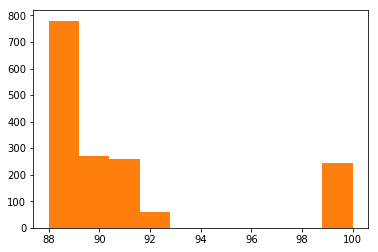

In [165]:
plt.hist(planattmeddf[planattmeddf['metallevel']=='Platinum'].issueractuarialvalue, bins=10)
plt.show()

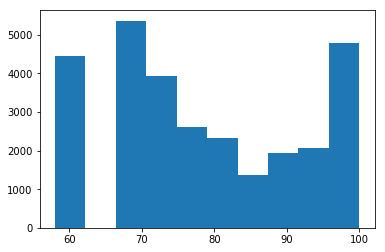

In [156]:
plt.hist(planattmeddf.issueractuarialvalue,bins=10)
plt.show()